# ML for Climate Project Code
Erin Choi, Vicky Lin (Breadiction)

# Data Preprocessing

In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn import metrics, model_selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, PoissonRegressor, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor

from xgboost import XGBRegressor

import random, math, string

from sklearn.metrics import mean_squared_log_error, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error

In [2]:
# import training data
df_train = pd.read_csv('../project/data/train.csv', 
                       usecols=['Agencia_ID', 'Cliente_ID', 'Producto_ID',
                                'Venta_uni_hoy', 'Venta_hoy', 'Demanda_uni_equil'])
df_train.head()

,Agencia_ID,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Demanda_uni_equil
0,1110,15766,1212,3,25.14,3
1,1110,15766,1216,4,33.52,4
2,1110,15766,1238,4,39.32,4
3,1110,15766,1240,4,33.52,4
4,1110,15766,1242,3,22.92,3


In [3]:
df_train.shape

(74180464, 6)

## Client Data Process

In [4]:
# import client table
df_client = pd.read_csv('../project/data/cliente_tabla.csv')
df_client.head()

,Cliente_ID,NombreCliente
0,0,SIN NOMBRE
1,1,OXXO XINANTECATL
2,2,SIN NOMBRE
3,3,EL MORENO
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT


In [5]:
# stopwords in spanish
from nltk.corpus import stopwords
stopwords = stopwords.words("spanish")
stopwords = [x.upper() for x in stopwords]

In [6]:
# common names in spanish
surnames = pd.read_csv('../project/data/surnames.csv')[:1000]
female = pd.read_csv('../project/data/female_names.csv')[:1000]
male = pd.read_csv('../project/data/male_names.csv')[:1000]

In [7]:
# create list of most common names
names = surnames['surname'].values
for n in female['name']:
    names = np.append(names, n)
for n in male['name']:
    names = np.append(names, n)

In [8]:
# split words in each client value, 
# add to client_words if they're not stopwords or whitespace
client_list = df_client['NombreCliente'].unique()
client_words = []

for c in client_list:
    c_list = c.split(' ')
    for w in c_list:
        if w not in stopwords and w not in string.whitespace:
            client_words.append(w)
client_words = [x.upper() for x in client_words]

In [9]:
# create a dataframe and find the unique client words
client_words = pd.DataFrame(client_words)
client_unique = client_words[0].unique()

In [10]:
# drop client words that are common names or shorter than 3 characters
for c in client_unique:
    if c in names or len(c) < 3:
        client_words.drop(client_words[client_words[0] == c].index, inplace = True)

In [11]:
# check most common client words with .value_counts()
client_types = client_words[0].value_counts(ascending=False)
client_types.head(25)

ABARROTES       12337
SUPER            9930
OXXO             6652
MISCELANEA       5892
COMODIN          5084
MINI             4024
SAN              3730
FARMACIA         3419
PAPELERIA        2471
TIENDA           2315
CREMERIA         2068
ESCUELA          2049
CASA             1958
PUESTO           1861
DON              1793
HAMBURGUESAS     1793
DICONSA          1611
MISC             1536
ABTS             1517
CAFETERIA        1516
CARNICERIA       1443
CENTRO           1402
ESC              1374
SANTA            1343
SECUNDARIA       1332
Name: 0, dtype: int64

In [12]:
# make names uppercase
df_client_new = df_client.copy()
df_client_new['NombreCliente'] = df_client_new['NombreCliente'].apply(str.upper)
# df_client_new.head()

In [13]:
# categorize the clients by type using specific search terms
# there will be many overlaps in the categories since we can't sort the names one by one

def categorize_client(df):
    
    # big companies and chains
    df['NombreCliente'] = df['NombreCliente'].replace(['.*WAL MART.*', '.*SAMS CLUB.*'],'Walmart', regex=True)
    df['NombreCliente'] = df['NombreCliente'].replace(['.*OXXO.*', '.*7 ELEVEN.*', '.*MODELORAMA.*'],
                                                          'Convenience', regex=True)
    df['NombreCliente'] = df['NombreCliente'].str.replace('.*BIMBO.*', 'Bimbo Store', regex=True)
    
    # supermarkets
    df['NombreCliente'] = df['NombreCliente'].str.replace('.*SUPER.*', 'Supermarket', regex=True)
    
    # general marts
    df['NombreCliente'] = df['NombreCliente'].replace(['.*COMERCIAL.*', '.*BODEGA.*', '.*DEPOSITO.*', '.*ABARROTES.*',\
                                                       '.*MERCADO.*', '.*CAMBIO.*', '.*MARKET.*', '.*MART.*', '.*MINI.*',\
                                                       '.*PLAZA.*', '.*MISC.*', '.*EXP.*', '.*SNACK.*', '.*PAPELERIA.*',\
                                                       '.*CARNICERIA.*', '.*LOCAL.*', '.*COMODIN.*', '.*PROVIDENCIA.*',\
                                                       '.*VERDU.*', '.*FRUT.*', '.*DULCE.*'], 'General Mart', regex=True)
    
    # restaurants/eateries
    df['NombreCliente'] = df['NombreCliente'].replace(['.*CAFE.*', '.*CREMERIA.*', '.*DULCERIA.*', '.*REST.*',\
                                                       '.*BURGER.*', '.*BURGU.*', '.*TACO.*', '.*TORTA.*', '.*TAQUER.*',\
                                                       '.*HOT DOG.*', '.*COMEDOR.*', '.*ERIA.*', '.*COCINA.*'],
                                                      'Restaurant', regex=True)
    
    # non food
    df['NombreCliente'] = df['NombreCliente'].replace(['.*COLEG.*', '.*UNIV.*', '.*ESCU.*', '.*INSTI.*',\
                                                       '.*SECUNDARIA.*', '.*PRIMARIA.*', '.*PREPAR.*'], 
                                                      'School', regex=True)
    df['NombreCliente'] = df['NombreCliente'].str.replace('.*PUESTO.*', 'Post', regex=True)
    df['NombreCliente'] = df['NombreCliente'].replace(['.*FARMA.*', '.*HOSPITAL.*', '.*CLINI.*'], 
                                                      'Hospital/Pharmacy', regex=True)
    df['NombreCliente'] = df['NombreCliente'].replace(['.*HOTEL.*', '.*MOTEL.*'],'Hotel', regex=True)
    

    # franchises with participles & numbers in the name, non-individuals
    df['NombreCliente'] = df['NombreCliente'].replace([
            '.*LA .*','.*EL .*','.*DE .*','.*LOS .*','.*DEL .*','.*Y .*', '.*SAN .*', '.*SANTA .*',\
            '.*AG .*','.*LAS .*','.*MI .*','.*MA .*', '.*II.*', '.*[0-9]+.*'], 'Small Franchise', regex=True)

In [14]:
# leftover names = individuals unless no name provided
def categorize_rest(df):
    def indiv_none(data):
        # check for uppercase = non-categorized clients
        if (data.isupper()) and (data != "NO IDENTIFICADO"): 
            return 'Individual'
        else:
            return data
    df['NombreCliente'] = df['NombreCliente'].map(indiv_none)

In [15]:
# run functions
categorize_client(df_client_new)

In [16]:
categorize_rest(df_client_new)

In [17]:
# check that categorization was successful
df_client_new['NombreCliente'].value_counts()

Individual           341485
NO IDENTIFICADO      281670
Small Franchise      156076
General Mart          90052
Restaurant            21870
Supermarket           16825
Convenience           11866
School                 6595
Hospital/Pharmacy      5203
Post                   2067
Hotel                  1113
Bimbo Store             320
Walmart                 220
Name: NombreCliente, dtype: int64

In [18]:
df_client_new.rename(columns={'NombreCliente':'client_type'}, inplace=True)
df_client_new.head()

,Cliente_ID,client_type
0,0,Individual
1,1,Convenience
2,2,Individual
3,3,Small Franchise
4,4,Small Franchise


In [20]:
# # save as new csv
# df_client_new.to_csv('../project/data/final_client.csv', encoding='utf-8')

In [19]:
del surnames
del female
del male
del names
del stopwords
del client_list
del client_words
del client_unique
del client_types
del df_client_new

## Product Data Process

In [21]:
# import product table
df_product = pd.read_csv('../project/data/producto_tabla.csv')
df_product.head()

,Producto_ID,NombreProducto
0,0,NO IDENTIFICADO 0
1,9,Capuccino Moka 750g NES 9
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41
3,53,Burritos Sincro 170g CU LON 53
4,72,Div Tira Mini Doradita 4p 45g TR 72


In [22]:
# get substrings containing the weight, product name, and brand from the product
import string

df_product["product_name"] = df_product['NombreProducto'].str.extract(r'^(.*?)(\d*\s\d+(kg|Kg|g|G|ml| ml|p|Reb)\s)', expand=False)[0]
df_product["product_weight"] = df_product['NombreProducto'].str.extract(r'^(.*?)(\d*\s\d+(kg|Kg|g|G|ml| ml|Reb)\s)')[1]
df_product['brand'] = df_product['NombreProducto'].str.extract(r'^.*\d+(kg|Kg|g|G|ml| ml|p|Reb)\s(.*?)\s\d+$', expand=False)[1]


In [23]:
df_product.head(10)

,Producto_ID,NombreProducto,product_name,product_weight,brand
0,0,NO IDENTIFICADO 0,NaN,NaN,NaN
1,9,Capuccino Moka 750g NES 9,Capuccino Moka,750g,NES
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,Bimbollos Ext sAjonjoli,480g,BIM
3,53,Burritos Sincro 170g CU LON 53,Burritos Sincro,170g,CU LON
4,72,Div Tira Mini Doradita 4p 45g TR 72,Div Tira Mini Doradita,45g,TR
5,73,Pan Multigrano Linaza 540g BIM 73,Pan Multigrano Linaza,540g,BIM
6,98,Tostado Integral 180g WON 98,Tostado Integral,180g,WON
7,99,Pan Blanco 567g WON 99,Pan Blanco,567g,WON
8,100,Super Pan Bco Ajonjoli 680g SP WON 100,Super Pan Bco Ajonjoli,680g,SP WON
9,106,Wonder 100pct mediano 475g WON 106,Wonder 100pct mediano,475g,WON


In [24]:
# check what rows have null weights
df_product.loc[df_product['product_weight'].isnull()]

,Producto_ID,NombreProducto,product_name,product_weight,brand
0,0,NO IDENTIFICADO 0,NaN,NaN,NaN
40,322,Tuinky Fresas con Crema 2p WON 322,Tuinky Fresas con Crema,NaN,WON
93,1166,Bollo Regular 2pq 30p McD BIM 1166,Bollo Regular 2pq,NaN,McD BIM
117,1289,Donas 6P Prom BIM 1289,NaN,NaN,NaN
127,1641,Doraditas 4p TR 1641,Doraditas,NaN,TR
162,2575,Vasos 226 8g8oz NES 2575,NaN,NaN,NaN
190,3509,Paletina para Cafe NES 3509,NaN,NaN,NaN
199,3609,Mantecadas Chocolate 3p TR 3609,Mantecadas Chocolate,NaN,TR
232,4240,Mantecadas 2p SP TR 4240,Mantecadas,NaN,SP TR
296,5707,Tostada Ondulada Tubo 30p MR 5707,Tostada Ondulada Tubo,NaN,MR


In [25]:
# manually add weight that weren't extracted
# weight:
# manually add available weights that weren't extracted
df_product.loc[162, 'product_weight'] = '8g'
df_product.loc[877, 'product_weight'] = '535g'
df_product.loc[1152, 'product_weight'] = '90g'
df_product.loc[1335, 'product_weight'] = '137g'
df_product.loc[1336, 'product_weight'] = '137g'
df_product.loc[1585, 'product_weight'] = '110g'
df_product.loc[1748, 'product_weight'] = '1360g'
df_product.loc[1749, 'product_weight'] = '1414g'
df_product.loc[1750, 'product_weight'] = '500g'
df_product.loc[1888, 'product_weight'] = '204g'
df_product.loc[1889, 'product_weight'] = '204g'
df_product.loc[1890, 'product_weight'] = '204g'
df_product.loc[1922, 'product_weight'] = '200g'

In [26]:
#check again
#df_product.loc[df_product['product_weight'].isnull()]
len(df_product.loc[df_product['product_weight'].isnull()])

36

In [27]:
# check which rows have null brand
df_product.loc[df_product['brand'].isnull()]

,Producto_ID,NombreProducto,product_name,product_weight,brand
0,0,NO IDENTIFICADO 0,NaN,NaN,NaN
117,1289,Donas 6P Prom BIM 1289,NaN,NaN,NaN
162,2575,Vasos 226 8g8oz NES 2575,NaN,8g,NaN
190,3509,Paletina para Cafe NES 3509,NaN,NaN,NaN
218,4118,Tortillas Bolsa 2a 1kg 4118,Tortillas Bolsa 2a,1kg,NaN
381,30099,Camioncitos Bimbo BIM 30099,NaN,NaN,NaN
409,30280,Camioncito Bimbo Modelo 3 BIM 30280,NaN,NaN,NaN
528,30958,Empanzador Crujiente Prom BIM 30958,NaN,NaN,NaN
1044,33862,Choco Roles Fresa 3X10 Prom MLA 33862,NaN,NaN,NaN
1045,33863,Choco Roles Fresa 3X10 Prom MTB MLA 33863,NaN,NaN,NaN


In [28]:
# do second extraction of brand 
# & drop any with numbers in the brand or no brand after this
brand_nan_ix = df_product[df_product['brand'].isnull()==True].index
for i in brand_nan_ix:
    name = df_product.loc[i,'NombreProducto']
    brand_name = name.split(" ")[-2]
    if brand_name.isalpha() == True:
            df_product.loc[i,'brand'] = brand_name

In [29]:
# only one product does not have brand
df_product.loc[df_product['brand'].isnull()]

,Producto_ID,NombreProducto,product_name,product_weight,brand
218,4118,Tortillas Bolsa 2a 1kg 4118,Tortillas Bolsa 2a,1kg,NaN


In [30]:
# drop product with no brand
df_product = df_product.drop([218], axis = 0)

In [31]:
# change all brands with fewer than 9 counts in product table to "Other"
#df_product['brand'].value_counts()
drop_ix = df_product['brand'].value_counts().loc[lambda x: x<10].index
df_product.loc[df_product['brand'].isin(drop_ix), 'brand'] = 'Other'

In [32]:
df_product.head()

,Producto_ID,NombreProducto,product_name,product_weight,brand
0,0,NO IDENTIFICADO 0,NaN,NaN,Other
1,9,Capuccino Moka 750g NES 9,Capuccino Moka,750g,Other
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,Bimbollos Ext sAjonjoli,480g,BIM
3,53,Burritos Sincro 170g CU LON 53,Burritos Sincro,170g,CU LON
4,72,Div Tira Mini Doradita 4p 45g TR 72,Div Tira Mini Doradita,45g,TR


In [33]:
# change all product names to uppercase
df_product['product_name'] = df_product['product_name'].astype('str')
df_product['product_name'] = [x.upper() for x in df_product['product_name']]
df_product.head()

,Producto_ID,NombreProducto,product_name,product_weight,brand
0,0,NO IDENTIFICADO 0,NAN,NaN,Other
1,9,Capuccino Moka 750g NES 9,CAPUCCINO MOKA,750g,Other
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,BIMBOLLOS EXT SAJONJOLI,480g,BIM
3,53,Burritos Sincro 170g CU LON 53,BURRITOS SINCRO,170g,CU LON
4,72,Div Tira Mini Doradita 4p 45g TR 72,DIV TIRA MINI DORADITA,45g,TR


In [34]:
# get categories of products from product names
# df_product['product_name'].value_counts()

In [35]:
# categorize product names by type using specific terms
# there will be overlaps in the categories since we can't sort the names one by one

def categorize_product(df):
    
    # cookie
    df['product_name'] = df['product_name'].replace(['.*DELICIOSA.*', '.*CANELITA.*', '.*SUAVICREMA.*',\
                                                     '.*CHOCOCHISPA.*', '.*BARRITA.*', '.*PLATIVOLO.*',\
                                                     '.*GALLETA.*', '.*TARTINA.*', '.*TRIKI.*', '.*PRINCIPE.*',\
                                                     '.*LORS.*', '.*POLVORON.*', '.*PASTISETA.*', '.*MARIAS.*',\
                                                     '.*SPONCH.*', '.*BESOS.*', '.*MAGNAS.*', '.*SURTIDO.*',\
                                                     '.*BOMBONETE.*', '.*DECANELA.*', '.*BISQUET.*', '.*COOKIE.*',\
                                                     '.*SURTIDO.*'], 'Cookies', regex=True)
    # loaf bread
    df['product_name'] = df['product_name'].replace(['.*PAN.*', '.*SILUETA.*', '.*WONDER.*', '.*DUTCH.*',\
                                                      '.*BREAD.*'], 'Loaf Bread', regex=True)
    # bun
    df['product_name'] = df['product_name'].replace(['.*MEDIAS NOCHES.*', '.*BIMBOLLO.*', '.*HOT DOG.*', '.*BOLLO.*',\
                                                     '.*COLCHONE.*', '.*SEMITA.*', '.*BUN.*', '.*TORTILLINA.*',\
                                                     '.*TORTILLA.*'], 'Buns', regex=True)
    # cracker
    df['product_name'] = df['product_name'].replace(['.*CANAPINA.*', '.*SALMA.*', '.*DORADITA.*', '.*BIMBUNUELO.*',\
                                                     '.*ANIMALITOS.*', '.*THINS.*', '.*PALITRIGOS.*', '.*CRACKER.*'], 
                                                    'Crackers', regex=True)
    # chips
    df['product_name'] = df['product_name'].replace(['.*TOSTAD.*', '.*TOTOPO.*', '.*NACHO.*', '.*CHIP.*', '.*CHURRITO.*',\
                                                     '.*RUNNERS.*'], 'Chips', regex=True)
    
    # Cake
    df['product_name'] = df['product_name'].replace(['.*ROLES.*', '.*NITO.*', '.*PINGUI.*', '.*GANSITO.*', '.*DALMATA.*',\
                                                     '.*CHOCOTORRO.*', '.*SUBMARINOS.*', '.*PANQUE.*', '.*NAPOLITANO.*',\
                                                     '.*ROCKO.*', '.*TUINKY.*', '.*PIPUCHO.*', '.*TWINKIE.*','.*NEGRITO.*',\
                                                     '.*RAZTACHOC.*', '.*PACHONCITOS.*', '.*BIMBOLUNCH.*', '.*NAPI.*',\
                                                     '.*CHOCOROL.*', '.*CAKE.*'], 'Cakes', regex=True)
        
    # Pastry
    df['product_name'] = df['product_name'].replace(['.*CONCHAS.*', '.*BIGOTE.*', '.*CUERNITO.*','.*MADALENA.*','.*OREJITA.*',\
                                                     '.*EMPANADITA.*', '.*REBANADA.*', '.*DONA.*', '.*DONITA.*', '.*DONUT.*',\
                                                     '.*MANTECADA.*', '.*MUFFIN.*'], 'Pastry', regex=True)
    
    # Bars
    df['product_name'] = df['product_name'].replace(['.*BRAN FRUT.*', '.*BARRA.*','.*BARRI.*', '.*BAR.*'], 
                                                    'Bars', regex=True)
    
    # Savory
    df['product_name'] = df['product_name'].replace(['.*SALADA.*', '.*SANDWICH.*' ,'.*BIMKINGO.*', '.*LONCHIBON.*',\
                                                     '.*BURRITO.*', '.*FIGATZA.*'], 'Savory', regex=True)
    
    # Drinks
    df['product_name'] = df['product_name'].replace(['.*COCA.*', '.*NECTAR.*', '.*SPRITE.*', '.*FANTA.*', '.*AGUA.*',\
                                                     '.*LATA.*', '.*SIDRAL.*', '.*YERBABUENA.*', '.*BOTELLA.*'], 
                                                    'Drink', regex=True)    

In [36]:
# remaining products categorized as Other
def other_products(df):
    def indiv_other(data):
        # check for uppercase = non-categorized products
        if (data.isupper()) and (data != "NO IDENTIFICADO"): 
            return 'Other'
        else:
            return data
    df['product_name'] = df['product_name'].map(indiv_other)

In [37]:
# run functions
categorize_product(df_product)

In [38]:
other_products(df_product)

In [39]:
# check categorization
df_product['product_name'].value_counts()

Cookies       742
Loaf Bread    315
Buns          312
Cakes         287
Other         280
Pastry        160
Chips         156
Bars          104
Crackers       93
Savory         74
Drink          68
Name: product_name, dtype: int64

In [40]:
# get rid of unit in the weights and adjust all units to g
import re
product_weight_adjust = []
for i in df_product["product_weight"].values:
    if type(i) != float:
        i = i.lower()
        if 'kg' in i:
            num = int(re.sub("[^\d\.]", "", i))*1000
        else:
            num = int(re.sub("[^\d\.]", "", i))
    else:
        num = None
    product_weight_adjust.append(num)
df_product['product_weight'] = product_weight_adjust

In [41]:
df_product.head()

,Producto_ID,NombreProducto,product_name,product_weight,brand
0,0,NO IDENTIFICADO 0,Other,NaN,Other
1,9,Capuccino Moka 750g NES 9,Other,750.0,Other
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,Buns,480.0,BIM
3,53,Burritos Sincro 170g CU LON 53,Savory,170.0,CU LON
4,72,Div Tira Mini Doradita 4p 45g TR 72,Crackers,45.0,TR


In [42]:
# drop full product name column
df_product.drop(columns='NombreProducto', inplace=True)
df_product.head()

,Producto_ID,product_name,product_weight,brand
0,0,Other,NaN,Other
1,9,Other,750.0,Other
2,41,Buns,480.0,BIM
3,53,Savory,170.0,CU LON
4,72,Crackers,45.0,TR


In [43]:
# rename product name -> type
df_product.rename(columns={'product_name':'product_type'}, inplace=True)
df_product.head()

,Producto_ID,product_type,product_weight,brand
0,0,Other,NaN,Other
1,9,Other,750.0,Other
2,41,Buns,480.0,BIM
3,53,Savory,170.0,CU LON
4,72,Crackers,45.0,TR


In [44]:
# save as new csv
# df_product_final.to_csv('/Users/bobolin/Desktop/Adv_DS_climate/project/out.csv', encoding='utf-8')
# df_product.to_csv('../project/data/final_product.csv', encoding='utf-8')

In [45]:
del drop_ix
del product_weight_adjust

## Town/State Data Process

In [46]:
# import town/state data, drop towns
df_town = pd.read_csv('../project/data/town_state.csv')
df_town.drop(columns='Town', inplace=True)
df_town.head()

,Agencia_ID,State
0,1110,"MÉXICO, D.F."
1,1111,"MÉXICO, D.F."
2,1112,ESTADO DE MÉXICO
3,1113,"MÉXICO, D.F."
4,1114,"MÉXICO, D.F."


In [47]:
len(df_town['State'].unique())

33

## Sample/Downsize Data and Join All Tables

In [52]:
df_client = pd.read_csv('../project/data/final_client.csv', 
                        usecols=['Cliente_ID', 'client_type'])

df_product = pd.read_csv('../project/data/final_product.csv',
                        usecols=['Producto_ID', 'product_type', 'product_weight', 'brand'])


In [53]:
df_client.shape

(935362, 2)

In [54]:
# remove no id clients to reduce data size
no_id_ix = df_client.loc[df_client['client_type']=='NO IDENTIFICADO'].index
df_client.drop(index=no_id_ix, inplace=True)
df_client.shape

(653692, 2)

In [55]:
df_train.shape

(74180464, 6)

In [56]:
# joins with training data

# join the town data
df_train = df_train.merge(df_town, left_on = 'Agencia_ID', right_on = 'Agencia_ID', how = 'inner')

# join the client table
df_train = df_train.merge(df_client, left_on = 'Cliente_ID', right_on = 'Cliente_ID', how ='inner')

# join the product table
df_train = df_train.merge(df_product, left_on = 'Producto_ID', right_on = 'Producto_ID', how ='inner')


In [57]:
df_train.shape

(61519517, 11)

In [58]:
df_train.head()

,Agencia_ID,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Demanda_uni_equil,State,client_type,product_type,product_weight,brand
0,1110,15766,1212,3,25.14,3,"MÉXICO, D.F.",Post,Cakes,120.0,BIM
1,1110,15766,1212,4,33.52,4,"MÉXICO, D.F.",Post,Cakes,120.0,BIM
2,1110,15766,1212,5,41.90,5,"MÉXICO, D.F.",Post,Cakes,120.0,BIM
3,1110,15766,1212,4,33.52,4,"MÉXICO, D.F.",Post,Cakes,120.0,BIM
4,1110,15766,1212,1,8.38,1,"MÉXICO, D.F.",Post,Cakes,120.0,BIM


In [59]:
# remove other brand rows to reduce data
other_brand_ix = df_train.loc[df_train['brand']=='Other'].index
df_train.drop(index=other_brand_ix, inplace=True)
df_train.shape

(56055767, 11)

In [61]:
sample_size = min(df_train['State'].value_counts()) #250892
df_train['State'].value_counts(ascending=True)[:5]

QUERETARO               250892
BAJA CALIFORNIA SUR     314584
Queretaro de Arteaga    362149
CAMPECHE                396880
TLAXCALA                402997
Name: State, dtype: int64

In [62]:
df_train_small = df_train.groupby(by='State', group_keys=False).apply(lambda x: x.sample(sample_size,
                                                                       random_state=42))

In [63]:
df_train = df_train_small

In [64]:
df_train.shape

(8279436, 11)

In [65]:
# delete other dataframe variables
del df_town
del df_product
del df_client
del df_train_small

In [66]:
# drop unneeded columns
df_train.drop(columns=['Agencia_ID', 'Cliente_ID', 'Producto_ID'], inplace=True)
df_train.head()

,Venta_uni_hoy,Venta_hoy,Demanda_uni_equil,State,client_type,product_type,product_weight,brand
52103826,1,6.00,1,AGUASCALIENTES,Supermarket,Pastry,60.0,MTA TR
17346019,8,171.12,8,AGUASCALIENTES,Restaurant,Loaf Bread,675.0,BIM
59751176,3,27.00,3,AGUASCALIENTES,Individual,Cookies,104.0,MTB TR
5220681,3,22.92,3,AGUASCALIENTES,Individual,Pastry,105.0,BIM
36081272,1,5.19,1,AGUASCALIENTES,Individual,Cakes,70.0,MTB MLA


In [67]:
# calculate item price based on the sales and unit sales columns
df_train['price'] = df_train['Venta_hoy']/df_train['Venta_uni_hoy']

In [68]:
df_train.head()

,Venta_uni_hoy,Venta_hoy,Demanda_uni_equil,State,client_type,product_type,product_weight,brand,price
52103826,1,6.00,1,AGUASCALIENTES,Supermarket,Pastry,60.0,MTA TR,6.00
17346019,8,171.12,8,AGUASCALIENTES,Restaurant,Loaf Bread,675.0,BIM,21.39
59751176,3,27.00,3,AGUASCALIENTES,Individual,Cookies,104.0,MTB TR,9.00
5220681,3,22.92,3,AGUASCALIENTES,Individual,Pastry,105.0,BIM,7.64
36081272,1,5.19,1,AGUASCALIENTES,Individual,Cakes,70.0,MTB MLA,5.19


In [69]:
df_train = df_train[['State', 'client_type', 'brand', 'product_type', 'product_weight', 'price', 'Demanda_uni_equil']]
df_train.rename(columns={'State':'state', 'Demanda_uni_equil':'demand'},
                inplace=True)
df_train.head()        

,state,client_type,brand,product_type,product_weight,price,demand
52103826,AGUASCALIENTES,Supermarket,MTA TR,Pastry,60.0,6.00,1
17346019,AGUASCALIENTES,Restaurant,BIM,Loaf Bread,675.0,21.39,8
59751176,AGUASCALIENTES,Individual,MTB TR,Cookies,104.0,9.00,3
5220681,AGUASCALIENTES,Individual,BIM,Pastry,105.0,7.64,3
36081272,AGUASCALIENTES,Individual,MTB MLA,Cakes,70.0,5.19,1


In [70]:
# saving joined data
# df_train.to_csv('../project/data/final_data.csv', encoding='utf-8') #4.6GB
# df_train.to_csv('final_data.csv', encoding='utf-8')

## Dropping Missing Values

In [71]:
df_train.shape

(8279436, 7)

In [72]:
df_train.isnull().sum()

state                 0
client_type           0
brand              3100
product_type          0
product_weight    21961
price             30972
demand                0
dtype: int64

In [73]:
# proportion of rows with missing data in training set
3100/8279436, 21961/8279436, 30972/8279436

(0.0003744216393483807, 0.002652475361848319, 0.0037408345206122735)

Missing data makes up <1% of the data.

In [74]:
# drop rows with null brand
brand_nan = df_train[df_train['brand'].isnull()==True].index
df_train.drop(index=brand_nan, inplace=True)

In [75]:
# drop rows with null weight
weight_nan = df_train[df_train['product_weight'].isnull()==True].index
df_train.drop(index=weight_nan, inplace=True)

In [76]:
# drop rows with null price
price_nan = df_train[df_train['price'].isnull()==True].index
df_train.drop(index=price_nan, inplace=True)

In [77]:
df_train.shape

(8226669, 7)

In [78]:
del brand_nan
del weight_nan
del price_nan

In [79]:
df_train.to_parquet('final_data.parquet.gzip',
                    compression='gzip',
                    index=False)

## Train/Test Split

In [80]:
# train_test_split
df_train = pd.read_parquet("final_data.parquet.gzip")
df_train.head()

,state,client_type,brand,product_type,product_weight,price,demand
52103826,AGUASCALIENTES,Supermarket,MTA TR,Pastry,60.0,6.00,1
17346019,AGUASCALIENTES,Restaurant,BIM,Loaf Bread,675.0,21.39,8
59751176,AGUASCALIENTES,Individual,MTB TR,Cookies,104.0,9.00,3
5220681,AGUASCALIENTES,Individual,BIM,Pastry,105.0,7.64,3
36081272,AGUASCALIENTES,Individual,MTB MLA,Cakes,70.0,5.19,1


In [81]:
# split train and test data with 80:20
df_label = df_train['demand']
df_feature = df_train.drop(['demand'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(df_feature, df_label, train_size = 0.8)

In [82]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6581335, 6), (1645334, 6), (6581335,), (1645334,))

In [83]:
X_train.head()

,state,client_type,brand,product_type,product_weight,price
26091449,CHIHUAHUA,Individual,Prom MTB MLA,Cookies,106.0,7.78
42080836,QUINTANA ROO,Small Franchise,BIM,Loaf Bread,360.0,15.85
21759426,HIDALGO,Small Franchise,MTB MLA,Cookies,113.0,6.25
55995488,COAHUILA,Individual,MTA BIM,Pastry,123.0,9.91
46427931,SAN LUIS POTOSÍ,Individual,BIM,Cakes,236.0,6.86


In [84]:
# # save split data (4 files)
# X_train.to_csv('xtrain.csv', encoding='utf-8')
# X_test.to_csv('xtest.csv', encoding='utf-8')
# y_train.to_csv('ytrain.csv', encoding='utf-8')
# y_test.to_csv('ytest.csv', encoding='utf-8')

In [85]:
del df_train

## Standardize Data

In [86]:
# numerical columns
num_cols = ['product_weight', 'price']

In [87]:
# robust scaler on numerical cols
scaler = RobustScaler().fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols]).astype('float32')
X_test[num_cols] = scaler.transform(X_test[num_cols]).astype('float32')

In [88]:
X_train.head()

,state,client_type,brand,product_type,product_weight,price
26091449,CHIHUAHUA,Individual,Prom MTB MLA,Cookies,-0.080000,-0.084507
42080836,QUINTANA ROO,Small Franchise,BIM,Loaf Bread,1.371429,1.052113
21759426,HIDALGO,Small Franchise,MTB MLA,Cookies,-0.040000,-0.300000
55995488,COAHUILA,Individual,MTA BIM,Pastry,0.017143,0.215493
46427931,SAN LUIS POTOSÍ,Individual,BIM,Cakes,0.662857,-0.214085


In [89]:
X_test.head()

,state,client_type,brand,product_type,product_weight,price
3561082,SINALOA,Individual,BIM,Pastry,0.028571,0.000000
46402949,TLAXCALA,Individual,BIM,Cakes,0.662857,-0.214085
60336657,CHIHUAHUA,Small Franchise,MTA BIM,Buns,2.057143,1.616901
19884040,HIDALGO,Individual,TR,Cakes,-0.114286,0.000000
60641592,CHIHUAHUA,Convenience,MTA BIM,Loaf Bread,3.200000,1.787324


## Encode Categorical Features
Also, changing datatypes and compressing files into parquet.gzip to save space

### Change target dtype & compress files

In [90]:
y_train = pd.DataFrame(y_train, columns=['demand'])
y_test = pd.DataFrame(y_test, columns=['demand'])

In [91]:
y_train.describe()

,demand
count,6.581335e+06
mean,7.305953e+00
std,2.388225e+01
min,0.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,6.000000e+00
max,4.997000e+03


In [92]:
y_test.describe()

,demand
count,1.645334e+06
mean,7.307143e+00
std,2.404806e+01
min,0.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,6.000000e+00
max,4.320000e+03


In [93]:
y_train = y_train.astype('int16')
y_test = y_test.astype('int16')

In [94]:
# y_train.to_parquet('ytrain_final.parquet.gzip',
#                   compression='gzip',
#                   index=False)
# y_test.to_parquet('ytest_final.parquet.gzip',
#                   compression='gzip',
#                   index=False)

In [95]:
# del y_train
# del y_test

### Test set

In [96]:
# list of categorical columns
cat_cols = ['state', 'client_type', 'brand', 'product_type']

In [97]:
X_test = pd.get_dummies(X_test, prefix=['state', 'client', 'brand', 'product'], 
                         dtype=np.uint8)

In [98]:
# drop one category for each feature to prevent overdetermination
# Colima = least populated MX state
X_test.drop(columns=['state_COLIMA', 'client_Walmart', 
                     'brand_Prom TAB MLA', 'product_Drink'],
            inplace=True)

In [99]:
X_test.columns

Index(['product_weight', 'price', 'state_AGUASCALIENTES',
       'state_BAJA CALIFORNIA NORTE', 'state_BAJA CALIFORNIA SUR',
       'state_CAMPECHE', 'state_CHIAPAS', 'state_CHIHUAHUA', 'state_COAHUILA',
       'state_DURANGO',
       ...
       'product_Bars', 'product_Buns', 'product_Cakes', 'product_Chips',
       'product_Cookies', 'product_Crackers', 'product_Loaf Bread',
       'product_Other', 'product_Pastry', 'product_Savory'],
      dtype='object', length=107)

In [100]:
X_test.head()

,product_weight,price,state_AGUASCALIENTES,state_BAJA CALIFORNIA NORTE,state_BAJA CALIFORNIA SUR,state_CAMPECHE,state_CHIAPAS,state_CHIHUAHUA,state_COAHUILA,state_DURANGO,...,product_Bars,product_Buns,product_Cakes,product_Chips,product_Cookies,product_Crackers,product_Loaf Bread,product_Other,product_Pastry,product_Savory
3561082,0.028571,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
46402949,0.662857,-0.214085,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
60336657,2.057143,1.616901,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
19884040,-0.114286,0.000000,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
60641592,3.200000,1.787324,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [101]:
X_test.shape

(1645334, 107)

In [102]:
X_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1645334 entries, 3561082 to 24765673
Columns: 107 entries, product_weight to product_Savory
dtypes: float32(2), uint8(105)
memory usage: 189.9 MB


In [103]:
# X_test.to_parquet('xtest_final.parquet.gzip',
#                   compression='gzip',
#                   index=False)

In [104]:
# del X_test

### Training set

In [105]:
X_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6581335 entries, 26091449 to 61316329
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   state           object 
 1   client_type     object 
 2   brand           object 
 3   product_type    object 
 4   product_weight  float32
 5   price           float32
dtypes: float32(2), object(4)
memory usage: 1.7 GB


In [106]:
X_train = pd.get_dummies(X_train, prefix=['state', 'client', 'brand', 'product'],
                          dtype=np.uint8)
X_train.drop(columns=['state_COLIMA', 'client_Walmart', 
                     'brand_Prom TAB MLA', 'product_Drink'],
            inplace=True)

In [107]:
X_train.head()

,product_weight,price,state_AGUASCALIENTES,state_BAJA CALIFORNIA NORTE,state_BAJA CALIFORNIA SUR,state_CAMPECHE,state_CHIAPAS,state_CHIHUAHUA,state_COAHUILA,state_DURANGO,...,product_Bars,product_Buns,product_Cakes,product_Chips,product_Cookies,product_Crackers,product_Loaf Bread,product_Other,product_Pastry,product_Savory
26091449,-0.080000,-0.084507,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
42080836,1.371429,1.052113,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21759426,-0.040000,-0.300000,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
55995488,0.017143,0.215493,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
46427931,0.662857,-0.214085,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [108]:
X_train.shape

(6581335, 108)

In [109]:
X_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6581335 entries, 26091449 to 61316329
Columns: 108 entries, product_weight to product_Savory
dtypes: float32(2), uint8(106)
memory usage: 765.7 MB


In [111]:
# X_train.to_parquet('xtrain_final.parquet.gzip',
#                    compression='gzip',
#                    index=False)

# Data Visualization

In [112]:
X_train[['product_weight', 'price']].describe()

,product_weight,price
count,6.581335e+06,6.581335e+06
mean,5.318121e-01,2.787335e-01
std,5.102870e+00,9.299783e-01
min,-6.571429e-01,-1.143662e+00
25%,-2.285714e-01,-2.140845e-01
50%,0.000000e+00,0.000000e+00
75%,7.714286e-01,7.859155e-01
max,1.382171e+03,9.019648e+02


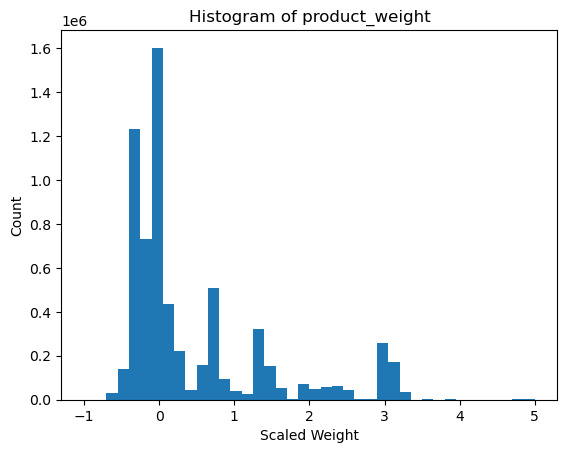

In [113]:
# scaled product weight distribution
plt.hist(X_train['product_weight'], bins=40, range=(-1,5))

plt.title('Histogram of product_weight')
plt.xlabel('Scaled Weight')
plt.ylabel('Count')
plt.show()

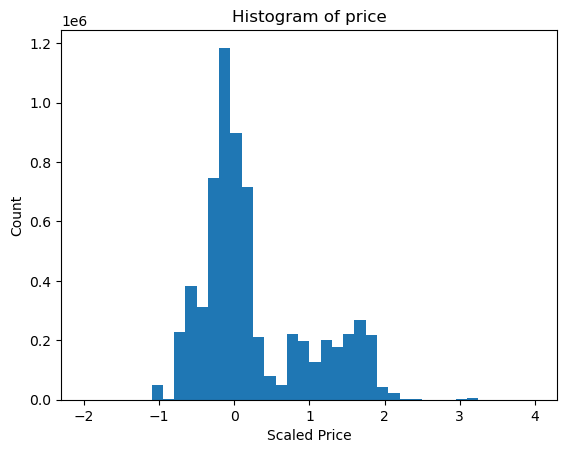

In [114]:
# scaled price distribution
plt.hist(X_train['price'], bins=40, range=(-2,4))

plt.title('Histogram of price')
plt.xlabel('Scaled Price')
plt.ylabel('Count')
plt.show()

In [115]:
y_train.describe()

,demand
count,6.581335e+06
mean,7.305953e+00
std,2.388225e+01
min,0.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,6.000000e+00
max,4.997000e+03


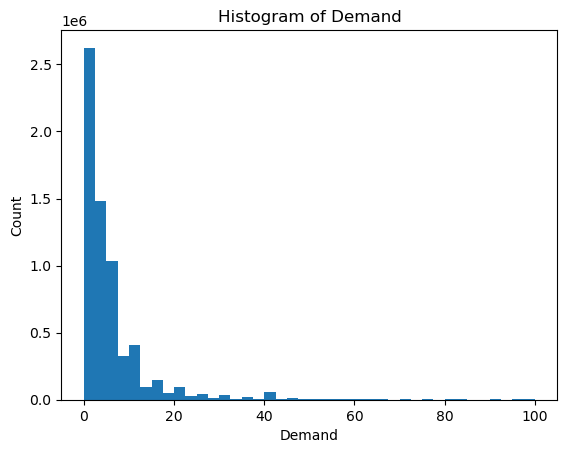

In [116]:
# target = demand distribution
plt.hist(y_train['demand'], bins=40, range=(0,100))

plt.title('Histogram of Demand')
plt.xlabel('Demand')
plt.ylabel('Count')
plt.show()

# Match column numbers in train/test data

In [3]:
X_train = pd.read_parquet("xtrain_final.parquet.gzip")
y_train = pd.read_parquet("ytrain_final.parquet.gzip")
X_test = pd.read_parquet("xtest_final.parquet.gzip")
y_test = pd.read_parquet("ytest_final.parquet.gzip")

In [5]:
X_train.isnull().sum()

In [9]:
for col in X_train.columns:
    if col not in X_test.columns:
        print(col)

In [10]:
# drop column - all rows with this brand were allocated to X_train
drop_brand_ix = X_train[X_train['brand_Cj DH']==1].index
X_train.drop(index=drop_brand_ix, inplace=True)
y_train.drop(index=drop_brand_ix, inplace=True)

In [11]:
X_train.drop(columns=['brand_Cj DH'], inplace=True)

In [12]:
X_train.shape, y_train.shape

((6581333, 107), (6581333, 1))

In [13]:
X_train.to_parquet('xtrain_final.parquet.gzip',
                  compression='gzip',
                  index=False)
y_train.to_parquet('ytrain_final.parquet.gzip',
                  compression='gzip',
                  index=False)

# Train & Hyperparameter Tune Models

In [3]:
# X_train = pd.read_parquet("xtrain_final.parquet.gzip")
# y_train = pd.read_parquet("ytrain_final.parquet.gzip")
# X_test = pd.read_parquet("xtest_final.parquet.gzip")
# y_test = pd.read_parquet("ytest_final.parquet.gzip")

## Linear Regression

In [4]:
# linear, ridge, lasso, adaboost, baggingregressor, xgboost
MODEL = []
RMSLE = []
MAE = []
MedAE = []
MAPE = []

In [5]:
# function for evaluating on training
def model_evals(y_true, y_pred):
    # turn negative predictions into 0
    y_pred[y_pred < 0] = 0
    
    #print out the result
    print("RMSLE:", mean_squared_log_error(y_true, y_pred, squared=False))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MedAE:", median_absolute_error(y_true, y_pred))
    print("MAPE:", mean_absolute_percentage_error(y_true, y_pred))

In [6]:
# function for evaluating on test
def model_evals_test(model, y_true, y_pred):
    # turn negative predictions into 0
    y_pred[y_pred < 0] = 0
    
    # store the result for the later dataframe
    rmsle = mean_squared_log_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    MODEL.append(model)
    RMSLE.append(rmsle)
    MAE.append(mae)
    MedAE.append(medae)
    MAPE.append(mape)
    
    #print out the result
    print("RMSLE:", rmsle)
    print("MAE:", mae)
    print("MedAE:", medae)
    print("MAPE:", mape)

In [53]:
# train the linear regression model
lr = LinearRegression().fit(X_train, y_train)

In [40]:
# make prediction on the train features
yPred1_train = lr.predict(X_train)
model_evals(y_train, yPred1_train)

RMSLE: 0.8960704
MAE: 6.315258
MedAE: 3.5545883
MAPE: 447308784219149.06


In [54]:
# make prediction on the test features
yPred1_test= lr.predict(X_test)
model_evals_test('Linear Regression', y_test, yPred1_test)

RMSLE: 0.89645326
MAE: 6.3222933
MedAE: 3.5568542
MAPE: 458072740179288.5


In [7]:
pr = PoissonRegressor().fit(X_train, y_train.values)

In [ ]:
yPred2_train = pr.predict(X_train)
# turn negative predictions into 0
yPred2_train[yPred2_train < 0] = 0

print("RMSLE:", mean_squared_log_error(y_train, yPred2_train, squared=False))
print("MAE:", mean_absolute_error(y_train, yPred2_train))
print("MedAE:", median_absolute_error(y_train, yPred2_train))
print("MAPE:", mean_absolute_percentage_error(y_train, yPred2_train))

In [ ]:
pr_weights = pd.DataFrame()
pr_weights['feature'] = np.array(X_train.columns)
pr_weights['weights'] = pr.coef_[0]
pr_weights

In [ ]:
pr_weights[pr_weights['weights']>0]

In [ ]:
# test on training data

# yPred1_test = lr.predict(pd.DataFrame(xTest))

print("RMSLE:", mean_squared_log_error(yTrain, yPred1_train, squared=False))
print("MAE:", mean_absolute_error(yTrain, yPred1_train))
print("MedAE:", median_absolute_error(yTrain, yPred1_train))
print("MAPE:", mean_absolute_percentage_error(yTrain, yPred1_train))

## Lasso Regression

In [57]:
lasso = Lasso(alpha=0.01, random_state=42).fit(X_train, y_train)

In [59]:
# predict on train features
lasso_pred_train = lasso.predict(X_train)
model_evals(y_train, lasso_pred_train)

RMSLE: 0.8992366
MAE: 6.3404865
MedAE: 3.6616554
MAPE: 448917168971858.6


In [60]:
# predict on test features
lasso_pred_test = lasso.predict(X_test)
model_evals_test('Lasso Regression', y_test, lasso_pred_test)

RMSLE: 0.8997714
MAE: 6.353492
MedAE: 3.6614819
MAPE: 459924211552118.7


## Ridge Regression

In [4]:
ridge = Ridge(alpha=0.1, random_state=42).fit(X_train, y_train)

In [61]:
# predict on train features
ridge_pred_train = ridge.predict(X_train)
model_evals(y_train, ridge_pred_train)

RMSLE: 0.8960823
MAE: 6.3153157
MedAE: 3.554634
MAPE: 447308745809818.44


In [63]:
# predict on test features
ridge_pred_test = ridge.predict(X_test)
model_evals_test('Ridge Regression', y_test, ridge_pred_test)

RMSLE: 0.89646465
MAE: 6.3223505
MedAE: 3.5568771
MAPE: 458080013901847.0


## XGBoost

In [22]:
# xgboost regressor orig
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42, seed=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [64]:
# predict on train features orig
xgb_pred_train = xgb_model.predict(X_train)
model_evals(y_train, xgb_pred_train)

RMSLE: 0.7151908
MAE: 4.859439
MedAE: 2.4731874
MAPE: 361687344370554.8


In [66]:
# predict on test features orig
xgb_pred_test = xgb_model.predict(X_test)
model_evals_test('XGBoost', y_test, xgb_pred_test)

RMSLE: 0.7163994
MAE: 4.8843694
MedAE: 2.4741693
MAPE: 375269092021322.7


## Bagging

In [27]:
# bagging regressor
bagged_trees = BaggingRegressor(
    base_estimator = DecisionTreeRegressor(max_depth=3), n_estimators=100)
bagged_trees.fit(X_train, y_train.values.ravel())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                 n_estimators=100)

In [68]:
# predict on train features
bagged_pred_train = bagged_trees.predict(X_train)
model_evals(y_train, bagged_pred_train)

RMSLE: 0.9311984969521092
MAE: 6.426065917716058
MedAE: 4.831723946101311
MAPE: 464045531151146.25


In [70]:
# predict on test features
bagged_pred_test = bagged_trees.predict(X_test)
model_evals_test('Bagging', y_test, bagged_pred_test)

RMSLE: 0.9318232449132862
MAE: 6.441883003606613
MedAE: 4.831723946101311
MAPE: 470627351978173.3


## AdaBoost

In [32]:
# train adaboost classifier
abc = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=1, criterion="squared_error", 
                          min_samples_split=50, random_state=42), 
    n_estimators=100, random_state=42).fit(X_train, y_train.values.ravel())

In [34]:
# predict on train features
abc_pred_train = abc.predict(X_train)
model_evals(y_train, abc_pred_train)

RMSLE: 1.2386611134497552
MAE: 9.639688930313826
MedAE: 8.493672714423834
MAPE: 747736005059773.1


In [33]:
# predict on test features new
abc_pred_test = abc.predict(X_test)
model_evals_test('AdaBoost', y_test, abc_pred_test)

RMSLE: 1.257163192153694
MAE: 10.046502425886548
MedAE: 8.493672714423834
MAPE: 760341892717934.0


# Evaluation Dataframe & Visualization

In [88]:
# rmsle, mae, medae, mape
# df_evals.drop([3], axis = 0, inplace = True)
df_evals.reset_index(drop=True, inplace=True)

In [65]:
df_evals

,Model,RMSLE,MAE,MedAE,MAPE
0,Linear Regression,0.896453,6.322293,3.556854,4.580727e+14
1,Lasso Regression,0.899771,6.353492,3.661482,4.599242e+14
2,Ridge Regression,0.896465,6.322351,3.556877,4.580800e+14
3,XGBoost,0.716399,4.884369,2.474169,3.752691e+14
4,Bagging,0.931823,6.441883,4.831724,4.706274e+14
5,AdaBoost,1.257163,10.046502,8.493673,7.603419e+14


In [64]:
# save the evals
df_evals.to_csv('models_evals.csv', encoding='utf-8', index=False)
# df_evals = pd.read_csv('models_evals.csv', index_col=0)

# Compare Models

In [66]:
# create/display dataframe with all the evaluation metrics
# print(plt.style.available)
plt.style.use('seaborn-v0_8-pastel')

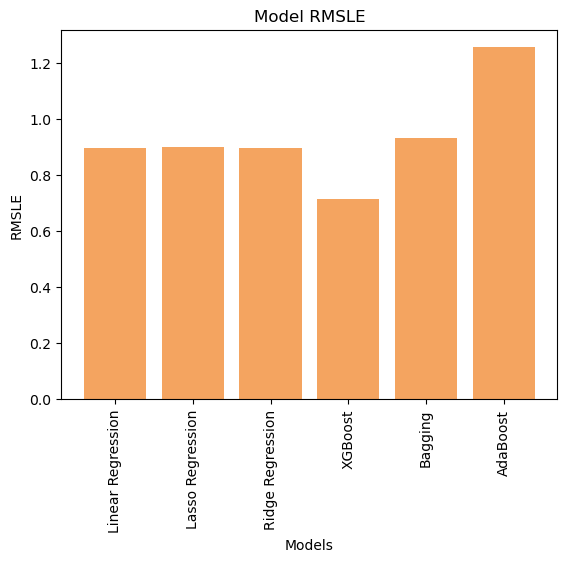

In [67]:
plt.bar(range(6), df_evals['RMSLE'], tick_label=df_evals['Model'],
       color='sandybrown')
plt.title("Model RMSLE")
plt.xlabel("Models")
plt.ylabel("RMSLE")
plt.xticks(rotation=90)
plt.show()

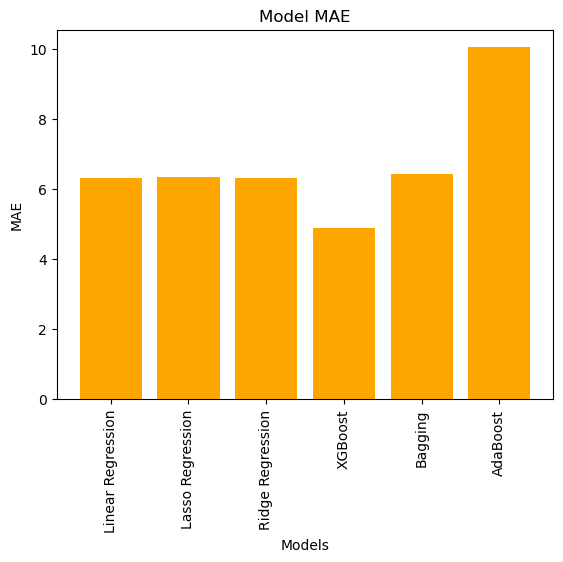

In [68]:
plt.bar(range(6), df_evals['MAE'], tick_label=df_evals['Model'],
       color='orange')
plt.title("Model MAE")
plt.xlabel("Models")
plt.ylabel("MAE")
plt.xticks(rotation=90)
plt.show()

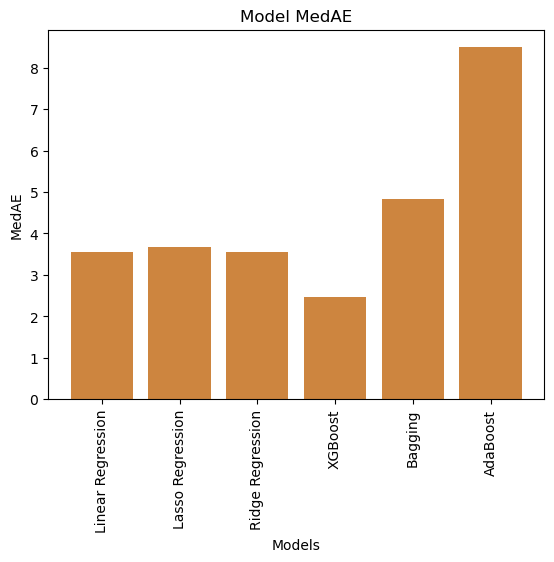

In [69]:
plt.bar(range(6), df_evals['MedAE'], tick_label=df_evals['Model'],
       color='peru')
plt.title("Model MedAE")
plt.xlabel("Models")
plt.ylabel("MedAE")
plt.xticks(rotation=90)
plt.show()

# Feature Importance in the best model

In [95]:
# methods vary
# for xgboost - information gain feature importances, there should be a function/method for this
feat_imp = xgb_model.feature_importances_
feat_list = list(X_train.columns)

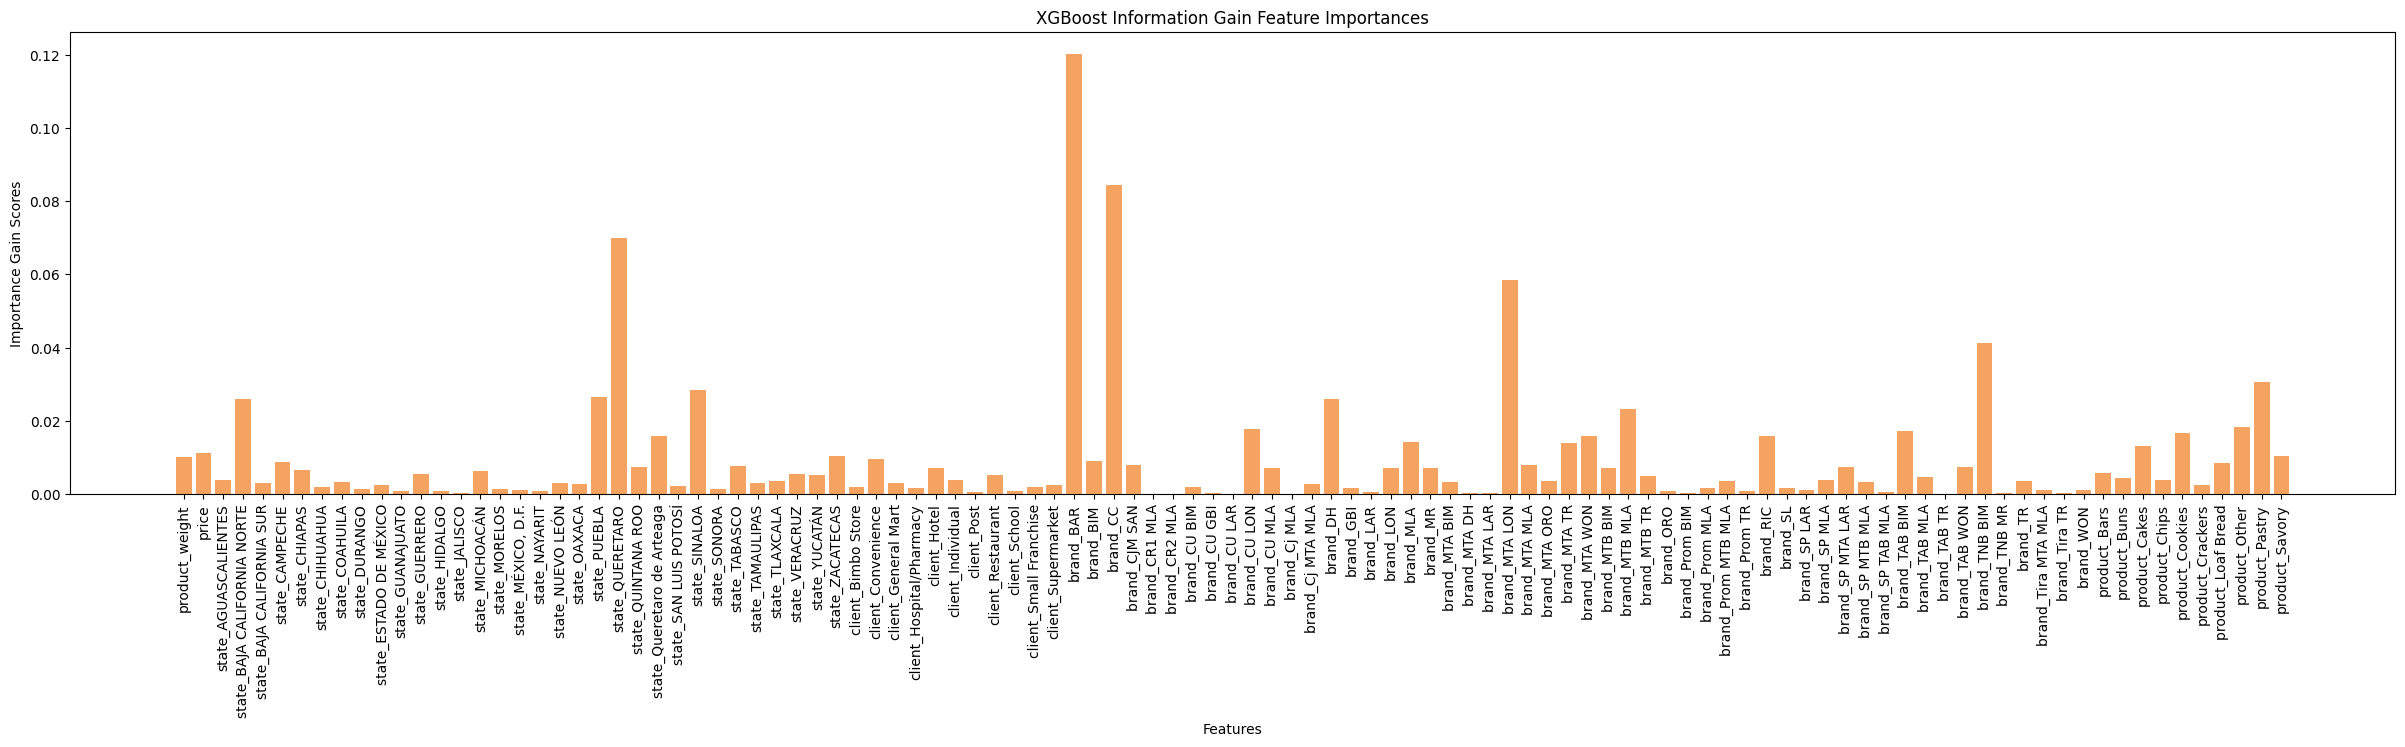

In [105]:
plt.figure(figsize=(30,6))
plt.bar(range(len(feat_imp)), feat_imp, tick_label = feat_list,
       color='sandybrown')
plt.title("XGBoost Information Gain Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Gain Scores")
plt.xticks(rotation=90)
plt.show()

In [108]:
# Order the features based on their importance
df_feature_importance = pd.DataFrame({'Feature': feat_list , 'Importance': feat_imp})
df_feature_importance.sort_values(by = ['Importance'], ascending = False, inplace = True)

In [120]:
top_20_feature = df_feature_importance[:20]
top_20_feature.reset_index(drop=True, inplace=True)
top_20_feature

,Feature,Importance
0,brand_BAR,0.120298
1,brand_CC,0.084348
2,state_QUERETARO,0.069850
3,brand_MTA LON,0.058350
4,brand_TNB BIM,0.041204
5,product_Pastry,0.030590
6,state_SINALOA,0.028307
7,state_PUEBLA,0.026467
8,brand_DH,0.025971
9,state_BAJA CALIFORNIA NORTE,0.025872


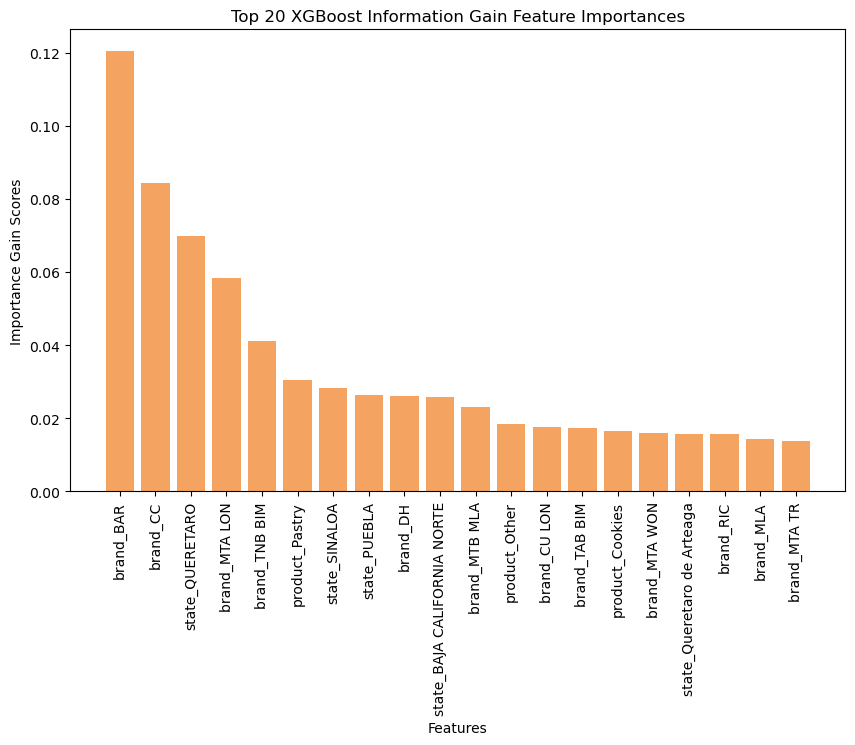

In [74]:
# top 20 features
plt.figure(figsize=(10,6))
plt.bar(range(len(top_20_feature['Feature'])), top_20_feature['Importance'], tick_label = top_20_feature['Feature'],
       color='sandybrown')
plt.title("Top 20 XGBoost Information Gain Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Gain Scores")
plt.xticks(rotation=90)
plt.show()

In [75]:
# save the evals
# df_feature_importance.to_csv('df_feature_importance.csv', encoding='utf-8')